# Study 3: Facial Expressions
Notes:
- might try normalizing facial expression betas between [0,5] so that we don't need to throw out negative betas

# Load Modules

In [1]:
%matplotlib inline

from collections import OrderedDict
import warnings
from copy import deepcopy
import glob
import os
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind, pearsonr, rankdata
from scipy.signal import detrend
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

from tqdm import tqdm

import statsmodels.formula.api as smf
from hmmlearn import hmm

import nibabel as nib
from nilearn.plotting import plot_epi,plot_anat,plot_glass_brain,plot_stat_map

from nltools.data import Brain_Data,Adjacency
from nltools.stats import (fisher_r_to_z, 
                           downsample, 
                           threshold, 
                           upsample, 
                           zscore, 
                           pearson, 
                           align,
                           winsorize, 
                           fdr, 
                           regress,
                           isc)
from nltools.mask import expand_mask, collapse_mask
from nltools.plotting import scatterplot

from fnl_tools.stats import (sort_subject_clusters, 
                             calc_fft, 
                             validity_index, 
                             extract_max_timeseries,
                             create_average_concordance,
                             calculate_r_square,
                             align_clusters_groups,
                             group_cluster_consensus,
                             calc_r_square,
                             global_zscore,
                             global_min_max_scaler,
                            )
from fnl_tools.plotting import (plot_raster,
                                plot_recurrence,
                                plot_avg_state_timeseries,
                                plot_wavelet,
                                plot_concordance,
                                frequency_color_func)
from fnl_tools.utils import get_rect_coord, rec_to_time
from fnl_tools.data import create_long_annotation, create_long_character_annotation

from emotioncf import create_sub_by_item_matrix
from emotioncf.cf import NNMF_sgd, Mean, KNN, NNMF_multiplicative

from feat import Fex
from feat.plotting import draw_lineface, draw_muscles, draw_vectorfield, plot_face, predict
from feat.utils import load_h5

from pymer4.models import Lm, Lmer

from wordcloud import WordCloud, get_single_color_func

warnings.filterwarnings('ignore')

base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

/Users/lukechang/anaconda3/lib/python3.7/site-packages/feat-0.0.1-py3.7.egg/feat/data.py:24: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index


## Load Data
- merge with concordance data

In [ ]:
roi = 32
k = 4
version = 'v4'
analysis = f'HMM_Combined_{version}'
study = 'Study2'

zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))

s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}_aligned.csv'), index_col=0)
# s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}.csv'), index_col=0)
# s2_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_study2_k{k}_ROI{roi}_v3.csv'), index_col=0)

s1_concordance = create_average_concordance(s1_dat)
# s2_concordance = create_average_concordance(s2_dat)

s1_concordance.columns = [f'S1_{x}' for x in s1_concordance.columns]
# s2_concordance.columns = [f'S2_{x}' for x in s2_concordance.columns]

file_list = glob.glob(os.path.join(base_dir,'Analyses','FaceExpression','*_FaceExpression_AU_0.5hz.csv'))
sub_out = []
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    tmp = center(pd.read_csv(f,index_col=0))
    au_list = tmp.columns
    tmp['Subject']  = sub
    tmp['Time'] = np.arange(0,tmp.shape[0])
    tmp = pd.concat([tmp, zscore(s1_concordance.iloc[:tmp.shape[0],:])], axis=1)
#     tmp = pd.concat([tmp, zscore(s1_concordance).iloc[:tmp.shape[0],:], zscore(s2_concordance).iloc[:tmp.shape[0],:]], axis=1)
    sub_out.append(tmp)
sub_out = pd.concat(sub_out)
sub_out.reset_index(inplace=True, drop=True)

# Reduce dimensionality with PCA
var_exp = .9
pca = PCA(n_components=var_exp)
reduced = pca.fit_transform(sub_out.loc[:, au_list])
n_components = reduced.shape[1]
reduced_df = pd.DataFrame(reduced)
reduced_df.columns = [f'c{x}' for x in reduced_df.columns]

sub_out = pd.concat([sub_out.drop(columns=au_list), reduced_df], axis=1)


# Predict State Concordance from Facial Expressions separately for each study
1. zscore each feature
2. stack subjects
3. predict mean of each state concordance


### Run for all k

In [15]:
roi = 32
version = 'v3'
analysis = f'HMM_Combined_{version}'

zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))

facet = load_h5('facet.h5')

for study in ['Study1', 'Study2']:
    r_square = {}
    for k in tqdm(range(2,26)):

        # Load Data
        if analysis == 'HMM_Combined_v4':
            s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}_aligned.csv'), index_col=0)
        elif analysis == 'HMM_Combined_v3':
            s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}.csv'), index_col=0)
        s1_concordance = create_average_concordance(s1_dat)
        s1_concordance.columns = [f'S1_{x}' for x in s1_concordance.columns]

        file_list = glob.glob(os.path.join(base_dir,'Analyses','FaceExpression','*_FaceExpression_AU_0.5hz.csv'))
        sub_out = []
        for f in file_list:
            sub = os.path.basename(f).split('_')[0]
            tmp = center(pd.read_csv(f,index_col=0))
            au_list = tmp.columns
            tmp['Subject']  = sub
            tmp['Time'] = np.arange(0,tmp.shape[0])
            tmp = pd.concat([tmp, zscore(s1_concordance.iloc[:tmp.shape[0],:])], axis=1)
            sub_out.append(tmp)
        sub_out = pd.concat(sub_out)
        sub_out.reset_index(inplace=True, drop=True)

        # Reduce Dimensionality with PCA
        var_exp = .9
        pca = PCA(n_components=var_exp)
        reduced = pca.fit_transform(sub_out.loc[:, au_list])
        n_components = reduced.shape[1]
        reduced_df = pd.DataFrame(reduced)
        reduced_df.columns = [f'c{x}' for x in reduced_df.columns]
        sub_out = pd.concat([sub_out.drop(columns=au_list), reduced_df], axis=1)

        # Run Regression
        states = [f'S1_State_{x}' for x in range(k)]
        regressors = ''.join([f'c{x}+' for x in range(n_components)])[:-1]
        r_square = {}
        au_models = {}
        for s in states:
        #     model = Lmer(f'{s} ~ AU1+AU2+AU4+AU5+AU6+AU7+AU9+AU10+AU12+AU14+AU15+AU17+AU18+AU20+AU23+AU24+AU25+AU26+AU28+AU43 + (1|Subject)', data=sub_out)
            model = Lmer(f'{s} ~ {regressors} + (1|Subject)', data=sub_out)
            model.fit()
            au_models[s] = model
            r_square[s] = calc_r_square(au_models[s].data[s], au_models[s].fits)

        # Generate Plot
        word_weights = pd.read_csv(os.path.join(base_dir,'Analyses','RatingsStateRegression', f'Emotion_Rating_{study}_k{k}_roi{roi}_{version}.csv'), index_col=0)
        word_weights = pd.DataFrame(minmax_scale(word_weights, feature_range=(0,100)), index=word_weights.index, columns=word_weights.columns)
        wc = WordCloud(background_color="white", repeat=False, color_func=frequency_color_func, relative_scaling=1)

        f,a = plt.subplots(ncols=4, nrows=len(states), figsize=(16, 5*len(states)))
        fex = {}
        for i,s in enumerate(states):
            coef = pd.Series(pca.inverse_transform(au_models[s].coefs['Estimate'].iloc[1:]), index=au_list)
        #     coef = au_models[s].coefs['Estimate'].iloc[1:]
            au = pd.Series(minmax_scale(coef, feature_range=(0,4)), index=coef.index)
            au.index = [int(x.split('AU')[1]) for x in coef.index]
            fex[s] = np.concatenate([au.sort_index().values, np.zeros(3)])
            muscles = {'all': 'heatmap'}
            neutral = predict(np.zeros(len(fex[s])), facet)
            vectors = {'target': predict(fex[s], facet),
                       'reference':  neutral, 'color': 'red'}

            plot_face(au=np.zeros(len(fex[s])), model=facet, ax=a[i,0])
            plot_face(au=fex[s], vectorfield=vectors, model=facet, ax=a[i,1])
            plot_face(au=fex[s], model=facet, muscles=muscles, ax=a[i,2])
            word_dict = dict(word_weights[s].astype(int))
            a[i,3].imshow(wc.generate_from_frequencies(word_dict), interpolation="bilinear")
            a[i,3].axis('off')
            a[i,1].set_title(s, fontsize=18)

        plt.savefig(os.path.join(base_dir,'Figures','FaceExpressionStateRegression', f'Face_Expression_State_Regression_wordcloud_{study}_k{k}_roi{roi}_{version}.png'))
        plt.close()
        pd.DataFrame(fex).to_csv(os.path.join(base_dir,'Analyses','FaceExpressionStateRegression', f'Face_Expression_State_Regression_{study}_k{k}_roi{roi}_AU_{version}.csv'), index=False)

    r_square = pd.Series(r_square)
    r_square.to_csv(os.path.join(base_dir,'Analyses','FaceExpressionStateRegression', f'Face_Expression_State_Regression_{study}_k{k}_roi{roi}_AU_r2_{version}.csv'), index=False)


  0%|          | 0/24 [00:00<?, ?it/s]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38447.883 	 AIC: 76895.767

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38447.883 	 AIC: 76895.767

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.995

No random effect correlations specified

Fixed effects:



  4%|▍         | 1/24 [00:19<07:27, 19.44s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38391.315 	 AIC: 76782.630

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.985  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38498.433 	 AIC: 76996.867

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

  8%|▊         | 2/24 [00:48<08:11, 22.33s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38392.733 	 AIC: 76785.465

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.985  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38528.804 	 AIC: 77057.609

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 12%|█▎        | 3/24 [01:25<09:22, 26.78s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38528.319 	 AIC: 77056.637

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38512.357 	 AIC: 77024.715

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 17%|█▋        | 4/24 [02:12<10:53, 32.66s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38495.003 	 AIC: 76990.006

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38399.767 	 AIC: 76799.533

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.986  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 21%|██        | 5/24 [03:06<12:26, 39.30s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38398.373 	 AIC: 76796.746

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.986  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38528.804 	 AIC: 77057.609

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 25%|██▌       | 6/24 [04:11<14:04, 46.90s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38528.804 	 AIC: 77057.609

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38494.093 	 AIC: 76988.187

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 29%|██▉       | 7/24 [05:27<15:44, 55.53s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38519.885 	 AIC: 77039.770

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38357.707 	 AIC: 76715.413

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.983  0.991

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 33%|███▎      | 8/24 [06:58<17:39, 66.21s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38523.527 	 AIC: 77047.054

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38385.311 	 AIC: 76770.621

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.985  0.992

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 38%|███▊      | 9/24 [08:30<18:29, 73.98s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38428.935 	 AIC: 76857.870

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.988  0.994

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38563.851 	 AIC: 77127.703

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.998  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 42%|████▏     | 10/24 [10:13<19:18, 82.77s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38528.804 	 AIC: 77057.609

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38439.961 	 AIC: 76879.923

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.994

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 46%|████▌     | 11/24 [12:13<20:20, 93.86s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38502.908 	 AIC: 77005.817

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38553.879 	 AIC: 77107.759

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.997  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 50%|█████     | 12/24 [14:26<21:06, 105.57s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38541.330 	 AIC: 77082.661

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.996  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38498.926 	 AIC: 76997.851

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 54%|█████▍    | 13/24 [16:53<21:37, 117.96s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38499.826 	 AIC: 76999.652

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38522.409 	 AIC: 77044.817

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 58%|█████▊    | 14/24 [19:17<20:59, 125.98s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38550.758 	 AIC: 77101.515

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.997  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38501.262 	 AIC: 77002.524

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 62%|██████▎   | 15/24 [21:54<20:16, 135.13s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38525.757 	 AIC: 77051.515

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38541.356 	 AIC: 77082.711

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.996  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 67%|██████▋   | 16/24 [24:37<19:09, 143.69s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38523.493 	 AIC: 77046.986

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38523.182 	 AIC: 77046.365

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 71%|███████   | 17/24 [27:33<17:52, 153.21s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38535.414 	 AIC: 77070.827

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.996  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38576.916 	 AIC: 77153.833

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.999  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 75%|███████▌  | 18/24 [31:04<17:03, 170.57s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38543.255 	 AIC: 77086.510

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.996  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38544.337 	 AIC: 77088.673

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.996  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 79%|███████▉  | 19/24 [34:26<14:59, 179.87s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38323.518 	 AIC: 76647.037

Random effects:

                 Name   Var   Std
Subject   (Intercept)  0.00  0.00
Residual               0.98  0.99

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38459.514 	 AIC: 76919.028

Random effects:

                 Name   Var    Std
Subject   (Intercept)  0.00  0.000
Residual               0.99  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of obse

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38518.209 	 AIC: 77036.417

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 20/24 [38:07<12:49, 192.41s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38449.793 	 AIC: 76899.586

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38433.309 	 AIC: 76866.618

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.988  0.994

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38552.250 	 AIC: 77104.501

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.997  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_21~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38430.888 	 AIC: 76861.777

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.988  0.994

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 21/24 [43:32<11:36, 232.08s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38456.417 	 AIC: 76912.834

Random effects:

                 Name   Var    Std
Subject   (Intercept)  0.00  0.000
Residual               0.99  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38554.230 	 AIC: 77108.460

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.997  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number o

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38573.218 	 AIC: 77146.436

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.998  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_21~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38528.804 	 AIC: 77057.609

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_22~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Nu

 92%|█████████▏| 22/24 [50:05<09:20, 280.33s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38493.396 	 AIC: 76986.793

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38559.285 	 AIC: 77118.570

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.997  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38442.543 	 AIC: 76885.087

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.994

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_21~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38323.842 	 AIC: 76647.683

Random effects:

                 Name   Var   Std
Subject   (Intercept)  0.00  0.00
Residual               0.98  0.99

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_22~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number o

 96%|█████████▌| 23/24 [56:51<05:18, 318.09s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38548.146 	 AIC: 77096.291

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.997  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38473.432 	 AIC: 76946.864

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.991  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38394.933 	 AIC: 76789.866

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.985  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_21~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38523.842 	 AIC: 77047.684

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_22~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Nu

  0%|          | 0/24 [00:00<?, ?it/s]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38389.631 	 AIC: 76779.262

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.985  0.992

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38389.631 	 AIC: 76779.262

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.985  0.992

No random effect correlations specified

Fixed effects:



  4%|▍         | 1/24 [00:19<07:38, 19.94s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38496.995 	 AIC: 76993.990

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38400.426 	 AIC: 76800.852

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.986  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

  8%|▊         | 2/24 [00:52<08:39, 23.63s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38526.995 	 AIC: 77053.990

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38362.916 	 AIC: 76725.832

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.983  0.992

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 12%|█▎        | 3/24 [01:31<09:56, 28.43s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38388.060 	 AIC: 76776.119

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.985  0.992

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38449.826 	 AIC: 76899.652

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 17%|█▋        | 4/24 [02:19<11:23, 34.17s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38352.510 	 AIC: 76705.020

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.982  0.991

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38450.650 	 AIC: 76901.301

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 21%|██        | 5/24 [03:44<15:40, 49.48s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38569.785 	 AIC: 77139.571

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.998  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38451.924 	 AIC: 76903.848

Random effects:

                 Name   Var    Std
Subject   (Intercept)  0.00  0.000
Residual               0.99  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number o

 25%|██▌       | 6/24 [05:33<20:11, 67.32s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38558.594 	 AIC: 77117.187

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.997  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38503.084 	 AIC: 77006.168

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 29%|██▉       | 7/24 [07:46<24:38, 86.97s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38526.995 	 AIC: 77053.990

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38562.033 	 AIC: 77124.067

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.998  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 33%|███▎      | 8/24 [10:09<27:39, 103.75s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38564.097 	 AIC: 77128.194

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.998  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38487.632 	 AIC: 76975.264

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.992  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 38%|███▊      | 9/24 [12:38<29:22, 117.52s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38492.650 	 AIC: 76985.299

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38517.030 	 AIC: 77034.061

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 42%|████▏     | 10/24 [15:32<31:18, 134.21s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38512.097 	 AIC: 77024.194

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38414.030 	 AIC: 76828.059

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.987  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 46%|████▌     | 11/24 [18:22<31:24, 144.96s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38417.396 	 AIC: 76834.792

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.987  0.994

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38581.432 	 AIC: 77162.864

Random effects:

                 Name    Var  Std
Subject   (Intercept)  0.000  0.0
Residual               0.999  1.0

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of o

 50%|█████     | 12/24 [21:29<31:32, 157.69s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38398.336 	 AIC: 76796.672

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.986  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38503.650 	 AIC: 77007.300

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 54%|█████▍    | 13/24 [24:48<31:12, 170.24s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38445.138 	 AIC: 76890.276

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38581.388 	 AIC: 77162.776

Random effects:

                 Name    Var  Std
Subject   (Intercept)  0.000  0.0
Residual               0.999  1.0

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of o

 58%|█████▊    | 14/24 [28:33<31:04, 186.43s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38570.349 	 AIC: 77140.698

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.998  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38485.065 	 AIC: 76970.130

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.992  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 62%|██████▎   | 15/24 [32:28<30:10, 201.14s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38491.381 	 AIC: 76982.762

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.992  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38520.630 	 AIC: 77041.260

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 67%|██████▋   | 16/24 [36:48<29:10, 218.79s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38505.745 	 AIC: 77011.491

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.993  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38411.105 	 AIC: 76822.210

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.987  0.993

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 71%|███████   | 17/24 [40:54<26:28, 226.89s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38508.451 	 AIC: 77016.901

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38431.413 	 AIC: 76862.827

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.988  0.994

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 75%|███████▌  | 18/24 [45:08<23:30, 235.06s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38469.677 	 AIC: 76939.354

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.991  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38518.541 	 AIC: 77037.082

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

 79%|███████▉  | 19/24 [49:48<20:43, 248.64s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38517.820 	 AIC: 77035.639

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38558.492 	 AIC: 77116.983

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.997  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38406.334 	 AIC: 76812.668

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.986  0.993

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 20/24 [54:28<17:11, 257.96s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38352.323 	 AIC: 76704.646

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.982  0.991

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38544.051 	 AIC: 77088.103

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.996  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38444.005 	 AIC: 76888.010

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.989  0.994

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_21~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38536.941 	 AIC: 77073.882

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.996  0.998

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 21/24 [59:53<13:53, 278.00s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38512.749 	 AIC: 77025.498

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38563.216 	 AIC: 77126.432

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.998  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Numbe

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38526.995 	 AIC: 77053.990

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.998

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_21~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38506.634 	 AIC: 77013.268

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_22~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Nu

 92%|█████████▏| 22/24 [1:03:49<08:51, 265.58s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38583.316 	 AIC: 77166.631

Random effects:

                 Name    Var  Std
Subject   (Intercept)  0.000  0.0
Residual               0.999  1.0

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38513.185 	 AIC: 77026.369

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.994  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of o

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38490.374 	 AIC: 76980.747

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.992  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_21~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38520.221 	 AIC: 77040.442

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.995  0.997

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_22~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Nu

 96%|█████████▌| 23/24 [1:07:22<04:09, 249.67s/it]

boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38463.076 	 AIC: 76926.153

Random effects:

                 Name   Var    Std
Subject   (Intercept)  0.00  0.000
Residual               0.99  0.995

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38586.217 	 AIC: 77172.433

Random effects:

                 Name    Var  Std
Subject   (Intercept)  0.000  0.0
Residual               0.999  1.0

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_2~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of obse

boundary (singular) fit: see ?isSingular 

Formula: S1_State_20~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38479.917 	 AIC: 76959.834

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.992  0.996

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_21~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 27180	 Groups: {'Subject': 20.0}

Log-likelihood: -38565.594 	 AIC: 77131.189

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.998  0.999

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see ?isSingular 

Formula: S1_State_22~c0+c1+c2+c3+c4+c5+c6+c7+(1|Subject)

Family: gaussian	 Inference: parametric

Nu

100%|██████████| 24/24 [1:11:07<00:00, 177.81s/it]


# Run Shared Response Model on State, Face Expression, and Rating to identify common latent space


In [2]:
k = 4
n_components = k
version = 'v3'
analysis = f'HMM_Combined_{version}'
roi = 32
cf_version = 'v3'
var_exp = .9
dilate_samples = 60

facet = load_h5('facet.h5')

zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))

# Load Concordance Data
if analysis == 'HMM_Combined_v4':
    s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_k{k}_ROI{roi}_{version}_aligned.csv'), index_col=0)
    s2_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_k{k}_ROI{roi}_{version}_aligned.csv'), index_col=0)
elif analysis == 'HMM_Combined_v3':
    s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_k{k}_ROI{roi}_{version}.csv'), index_col=0)
    s2_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_k{k}_ROI{roi}_{version}.csv'), index_col=0)
s1_concordance = zscore(create_average_concordance(s1_dat))
s2_concordance = zscore(create_average_concordance(s2_dat))

# Create average AU by Time
file_list = glob.glob(os.path.join(base_dir,'Analyses','FaceExpression','*_FaceExpression_AU_0.5hz.csv'))
sub_out = []
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    tmp = center(pd.read_csv(f,index_col=0))
    au_list = tmp.columns
    tmp['Subject']  = sub
    sub_out.append(tmp)
sub_out = pd.concat(sub_out)
sub_out.reset_index(inplace=True, drop=True)
au_mean = {}
for au in list(sub_out.columns[:-1]):
    au_subs = {}
    for sub in sub_out['Subject'].unique():
        au_subs[sub] = sub_out.query('Subject==@sub')[au].values
    au_mean[au] = pd.DataFrame(au_subs).mean(axis=1)
au_mean = zscore(pd.DataFrame(au_mean))

# Create average Rating by Time
file = open(os.path.join(base_dir, 'Data', 'CollaborativeFiltering','sparse.json'), 'r') 
ratings = json.loads(file.read())
all_data = {}
for name in ratings.keys():
    all_data[name] = pd.read_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', f'FNL_EmotionCF_{name}_NNMF_SGD_Dilate{dilate_samples}_{cf_version}.csv'), index_col=0).T
ratings_mean = {}
for emo in all_data:
    ratings_mean[emo] = center(downsample(all_data[emo], sampling_freq=1, target=.5, target_type='hz')).mean(axis=1)
ratings_mean = center(global_zscore(pd.DataFrame(ratings_mean)))

# Train SRM
data = [s1_concordance.values, s2_concordance.values, au_mean.values, ratings_mean.values]
shortest_length = np.min([x.shape[0] for x in data])
data = [x[:shortest_length,:] for x in data]

aligned = align(data, n_features=n_components, method='deterministic_srm')
s1_concord_wt, s2_concord_wt, au_wt, rating_wt = aligned['transformation_matrix']
s1_concord_ts, s2_concord_ts, au_ts, rating_ts = aligned['transformed']
print(aligned['isc'])

{0: 0.2469126612436474, 1: 0.2343285501023876, 2: 0.18631734765173924, 3: 0.26002581602982444}


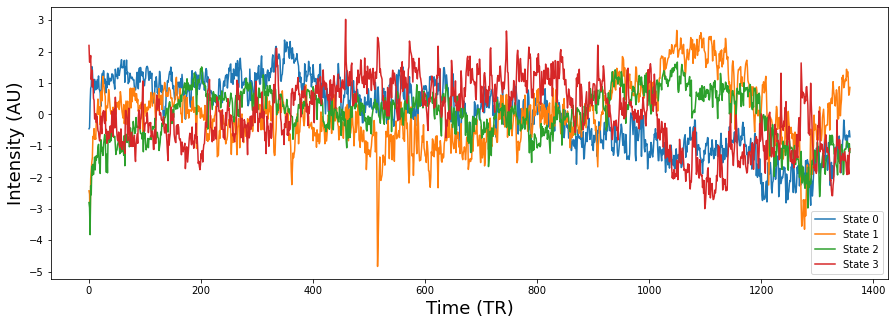

In [156]:
f,a = plt.subplots(figsize=(15,5))
a.plot(aligned['common_model'])
a.set_ylabel('Intensity (AU)', fontsize=18)
a.set_xlabel('Time (TR)', fontsize=18)
plt.legend([f'State {x}' for x in range(n_components)])
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_Common_Timeseries_k{k}_{version}.pdf'))


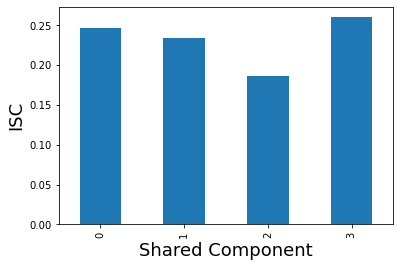

In [145]:
pd.Series(aligned['isc']).plot(kind='bar')
plt.xlabel('Shared Component', fontsize=18)
plt.ylabel('ISC', fontsize=18)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_ISC_k{k}_{version}.pdf'))


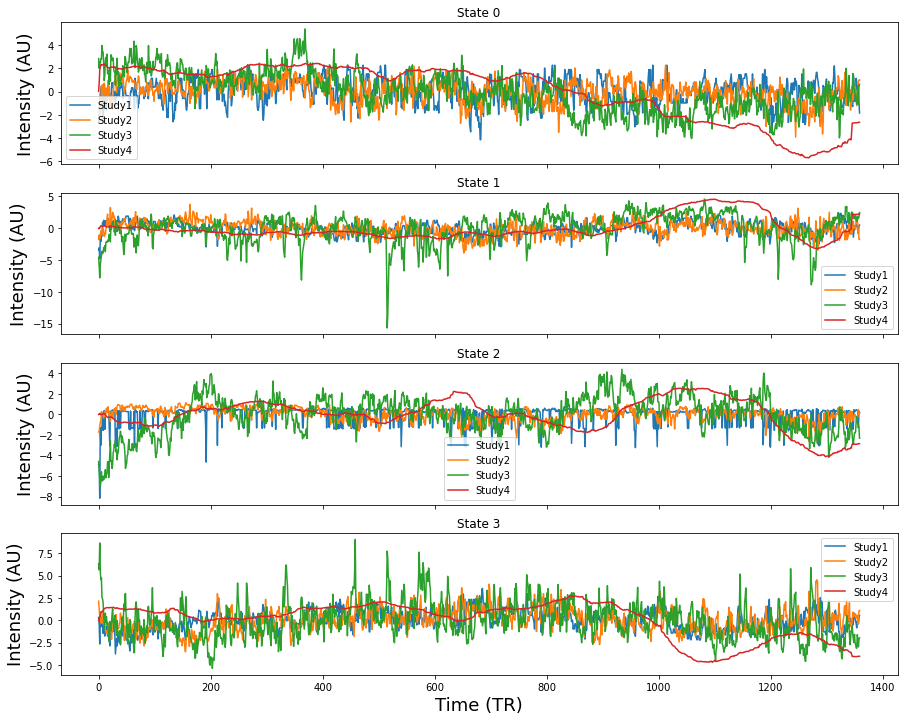

In [146]:
f,a = plt.subplots(nrows=n_components, figsize=(15, 3*n_components), sharex=True)

for i,s in enumerate(range(n_components)):
    pd.DataFrame(np.vstack([s1_concord_ts[s,:], s2_concord_ts[s,:], au_ts[s,:], rating_ts[s,:]]).T, columns=['Study1', 'Study2','Study3','Study4']).plot(ax=a[i])
#     pd.DataFrame(np.vstack([au_ts[s,:], rating_ts[s,:]]).T, columns=['Study3','Study4']).plot(ax=a[i])
    a[i].set_title(f'State {s}')
    a[i].set_ylabel('Intensity (AU)', fontsize=18)
a[i].set_xlabel('Time (TR)', fontsize=18)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_Timeseries_k{k}_{version}.pdf'))
    

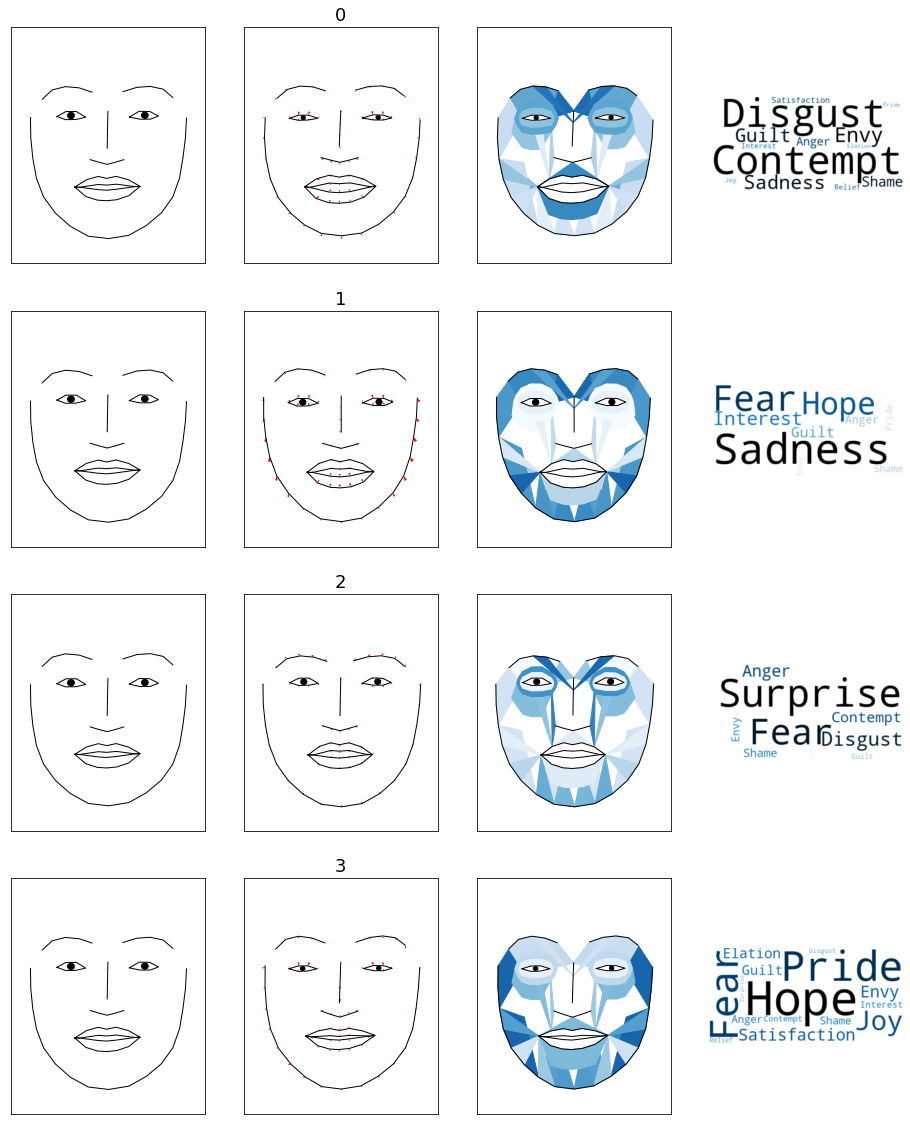

In [3]:
def frequency_color_func(word, hue=205, saturation_scaling=1.2, lightness_scaling=1.2, **kwargs):
    '''color helper function for word cloud plots'''
    return f"hsl({hue}, {saturation_scaling*word_dict[word]}%, {lightness_scaling*(100-word_dict[word])}%)"

f,a = plt.subplots(ncols=4, nrows=n_components, figsize=(16, 5*n_components))
fex = {}
for i,s in enumerate(range(n_components)):
    au = pd.Series(minmax_scale(au_wt[:,s], feature_range=(0,4)), index=list(au_mean.columns))
    au.index = [int(x.split('AU')[1]) for x in au_list]
    fex[s] = np.concatenate([au.sort_index().values, np.zeros(3)])
    muscles = {'all': 'heatmap'}
    neutral = predict(np.zeros(len(fex[s])), facet)
    vectors = {'target': predict(fex[s], facet),
               'reference':  neutral, 'color': 'red'}

    plot_face(au=np.zeros(len(fex[s])), model=facet, ax=a[i,0])
    plot_face(au=fex[s], vectorfield=vectors, model=facet, ax=a[i,1])
    plot_face(au=fex[s], model=facet, muscles=muscles, ax=a[i,2])
    
    word_weights = pd.DataFrame(minmax_scale(rating_wt, feature_range=(0, 100)), index=list(ratings_mean.columns))
    word_dict = dict(word_weights[s].astype(int))
    wc = WordCloud(background_color="white", repeat=False, color_func=frequency_color_func, relative_scaling=1)
    a[i,3].imshow(wc.generate_from_frequencies(word_dict), interpolation="bilinear")
    a[i,3].axis('off')
    a[i,1].set_title(s, fontsize=18)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_Emotion_k{k}_{version}.pdf'))

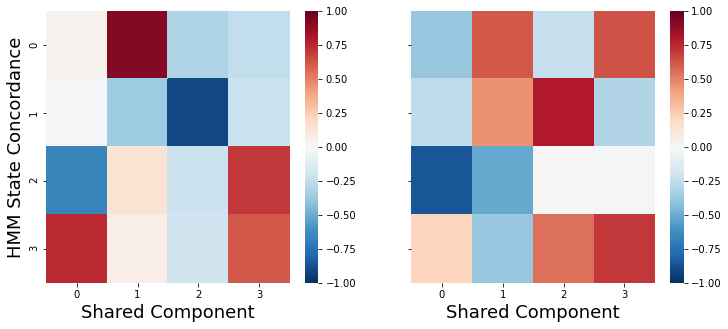

In [182]:
f,a = plt.subplots(ncols=2, figsize=(12,5), sharey=True)
sns.heatmap(s1_concord_wt, cmap='RdBu_r', ax=a[0], vmin=-1, vmax=1)
sns.heatmap(s2_concord_wt, cmap='RdBu_r', ax=a[1], vmin=-1, vmax=1)
a[0].set_ylabel('HMM State Concordance', fontsize=18)
a[0].set_xlabel('Shared Component', fontsize=18)
a[1].set_xlabel('Shared Component', fontsize=18)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_HMM_Weights_k{k}_{version}.pdf'))

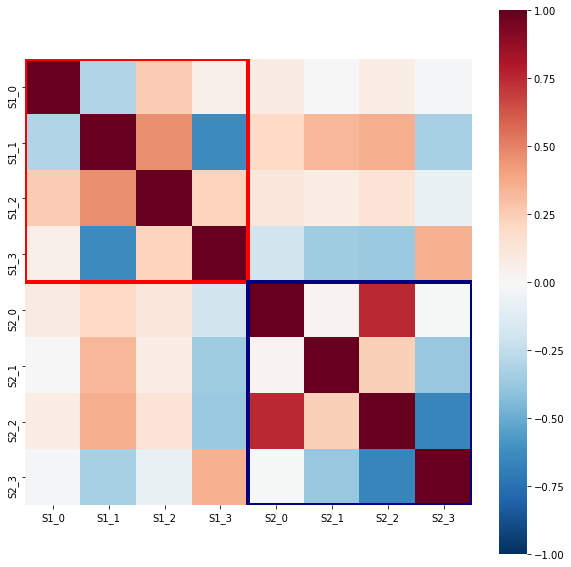

In [183]:
f,a = plt.subplots(figsize=(10,10))
# sns.heatmap(1 - pairwise_distances(np.concatenate([s1_concord_ts.T, s2_concord_ts.T], axis=1).T, metric='correlation'),
sns.heatmap(1 - pairwise_distances(np.concatenate([s1_concord_ts.T, s2_concord_ts.T], axis=1).T, metric='correlation'),
            cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=[f'S1_{i}' for i in range(k)] + [f'S2_{i}' for i in range(k)],
           yticklabels=[f'S1_{i}' for i in range(k)] + [f'S2_{i}' for i in range(k)], square=True, ax=a)
rect = patches.Rectangle((0,0), 4, 4, linewidth=4, edgecolor='red', facecolor='none')
a.add_patch(rect)
rect = patches.Rectangle((4,4), 4, 4, linewidth=4, edgecolor='navy', facecolor='none')
a.add_patch(rect)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Brain_Experiments_HMM_Concordance_k{k}_ROI{roi}_{version}.pdf'))

In [171]:
f,a = plt.subplots(figsize=(10,10))
# sns.heatmap(1 - pairwise_distances(np.concatenate([s1_concord_ts.T, s2_concord_ts.T], axis=1).T, metric='correlation'),
sns.heatmap(1 - pairwise_distances(np.concatenate([s1_concord_ts.T, s2_concord_ts.T], axis=1).T, metric='correlation'),
            cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=[f'S1_{i}' for i in range(k)] + [f'S2_{i}' for i in range(k)],
           yticklabels=[f'S1_{i}' for i in range(k)] + [f'S2_{i}' for i in range(k)], square=True, ax=a)
rect = patches.Rectangle((0,0), 4, 4, linewidth=4, edgecolor='red', facecolor='none')
a.add_patch(rect)
rect = patches.Rectangle((4,4), 4, 4, linewidth=4, edgecolor='navy', facecolor='none')
a.add_patch(rect)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_HMM_Weights_k{k}_{version}.pdf'))

['S1_0', 'S1_1', 'S1_2', 'S1_3', 'S2_0', 'S2_1', 'S2_2', 'S2_3']

## Make Supplemental Plot

In [ ]:
scale = 8
facet = load_h5('facet.h5')

f,a = plt.subplots(ncols=4, nrows=2, figsize=(14,8))
component = 11
au = pd.Series(pca.components_[:,component]*sign, index=emo_list)
au.index = [int(x.split('AU')[1]) for x in au.index]
au = np.concatenate([au.sort_index().values,np.zeros(3)])
muscles = {'all': 'heatmap'}
neutral = predict(np.zeros(len(au)),facet)
vectors = {'target': predict(au*scale, facet),
           'reference':  neutral, 'color': 'red'}
plot_face(au=np.zeros(len(au)), model=facet,ax=a[0,0])
plot_face(au=au*scale, model=facet,ax=a[0,1])
plot_face(au=au*scale, vectorfield=vectors, model=facet, ax=a[0,2])
plot_face(au=au*scale, model=facet,muscles=muscles, ax=a[0,3])

component = 3
au = pd.Series(pca.components_[:,component]*sign, index=emo_list)
au.index = [int(x.split('AU')[1]) for x in au.index]
au = np.concatenate([au.sort_index().values,np.zeros(3)])
muscles = {'all': 'heatmap'}
neutral = predict(np.zeros(len(au)),facet)
vectors = {'target': predict(au*scale, facet),
           'reference':  neutral, 'color': 'red'}
plot_face(au=np.zeros(len(au)), model=facet,ax=a[1,0])
plot_face(au=au*scale, model=facet,ax=a[1,1])
plot_face(au=au*scale, vectorfield=vectors, model=facet, ax=a[1,2])
plot_face(au=au*scale, model=facet,muscles=muscles, ax=a[1,3])

# f,a = plt.subplots(ncols=2, figsize=(8,4))
# plot_face(au=au*scale, model=facet,ax=a[0])
# plot_face(au=au*scale, vectorfield=vectors, model=facet, ax=a[1])
plt.tight_layout()
plt.savefig(os.path.join(base_dir,'Figures','FaceExpression', 'Face_Expression_AU_All.pdf'))
plt.savefig(os.path.join(base_dir,'Figures','FaceExpression',' Face_Expression_AU_All.png'))


In [4]:
fex

{0: array([3.92320501, 2.65077048, 3.720985  , 0.80194002, 2.00046349,
        2.71683953, 1.56330185, 0.59356747, 2.02635883, 2.54136432,
        0.47627838, 0.94126082, 1.01136025, 3.3495627 , 0.        ,
        1.18695877, 2.0599621 , 2.57314325, 3.04671442, 4.        ,
        0.        , 0.        , 0.        ]),
 1: array([3.9917755 , 3.34435017, 2.84270971, 2.09949562, 0.        ,
        0.03625808, 1.32249437, 0.37142831, 0.79881915, 1.75087385,
        3.09459921, 3.2654349 , 4.        , 1.49876786, 2.85928947,
        3.00027739, 0.39631536, 1.06181682, 1.85490625, 3.05742624,
        0.        , 0.        , 0.        ]),
 2: array([1.96653474, 0.04229801, 4.        , 1.38207981, 2.21186949,
        3.16597341, 3.4802168 , 2.07318725, 0.45380118, 0.        ,
        2.59157652, 2.35813907, 1.47998212, 0.57611498, 0.85988372,
        0.91748161, 0.33832501, 0.22472718, 0.53972742, 1.64430597,
        0.        , 0.        , 0.        ]),
 3: array([1.33032008, 1.18734421, 0.

# Get AU Muscles
https://imotions.com/blog/facial-action-coding-system/

In [12]:
s=1
au = pd.Series(minmax_scale(au_wt[:,s], feature_range=(0,4)), index=list(au_mean.columns))
au.index = [int(x.split('AU')[1]) for x in au_list]
au.sort_values()

6     0.000000
7     0.036258
10    0.371428
25    0.396315
12    0.798819
26    1.061817
9     1.322494
20    1.498768
14    1.750874
28    1.854906
5     2.099496
4     2.842710
23    2.859289
24    3.000277
43    3.057426
15    3.094599
17    3.265435
2     3.344350
1     3.991776
18    4.000000
dtype: float64

In [18]:
word_weights[1].sort_values()

Satisfaction      0.000000
Joy               0.338154
Elation           1.927009
Disgust           5.815179
Relief            8.474394
Surprise         18.280990
Contempt         19.734493
Envy             26.806076
Pride            30.888959
Shame            34.655543
Anger            39.630082
Guilt            50.013998
Interest         65.353814
Hope             75.757248
Fear             85.629011
Sadness         100.000000
Name: 1, dtype: float64